# Laboratiorio de RDDs

In [13]:
from pyspark.sql import SparkSession

# Initialize Spark session with cluster master
spark = SparkSession.builder \
    .appName("Lab2.1") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.memory.fraction", "0.6") \
    .config("spark.memory.storageFraction", "0.5") \
    .getOrCreate()

sc = spark.sparkContext

25/05/29 19:49:30 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
# Cargar CSV y extraer columna de texto como RDD
reviews_rdd = sc.textFile("/data/Books_rating.csv")
books_rdd = sc.textFile("/data/books_data.csv")

textFile() lee un archivo de texto (o directorio) y lo devuelve como un RDD de strings.

Cada línea del archivo se convierte en un elemento del RDD.

In [3]:
print(f"Número de reviews: {reviews_rdd.count()}")
print(f"Número de libros: {books_rdd.count()}")

Número de reviews: 3000001
Número de libros: 212405


## Comparación de rendimiento con/sin caching

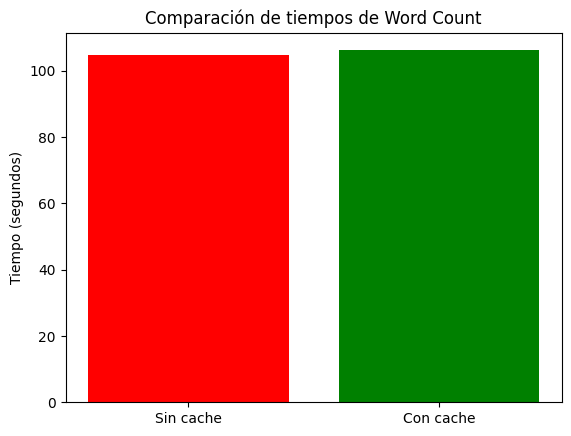

In [27]:
# Celda 3: Word Count con comparación de caching
def run_word_count(rdd, use_cache=False):
    start = time()
    
    if use_cache:
        rdd = rdd.cache()
    
    word_count = (
        rdd
        .flatMap(lambda line: line.split(" "))
        .map(lambda word: (word.lower(), 1))
        .reduceByKey(lambda a, b: a + b)
    )
    
    count = word_count.count()
    elapsed = time() - start
    
    if use_cache:
        rdd.unpersist()
        
    return elapsed

# Ejecutar y comparar
time_no_cache = run_word_count(reviews_rdd, False)
time_cache = run_word_count(reviews_rdd, True)

# Visualización
plt.bar(["Sin cache", "Con cache"], [time_no_cache, time_cache], color=["red", "green"])
plt.title("Comparación de tiempos de Word Count")
plt.ylabel("Tiempo (segundos)")
plt.show()

**Explicación de transformaciones:**

1. flatMap(): Divide cada línea en palabras y "aplana" los resultados en un solo RDD.

2. map(): Transforma cada palabra en un par (palabra en minúscula, 1).

3. reduceByKey(): Combina los valores para cada clave usando una función (suma en este caso).

**Explicación de caching:**

1. cache(): Persiste el RDD en memoria para reutilización futura.

2. unpersist(): Elimina el RDD de la memoria cuando ya no se necesita.

In [29]:
print(time_no_cache)
print(time_cache)

104.74665451049805
106.14357495307922


In [7]:
from pyspark import StorageLevel
from time import time
import matplotlib.pyplot as plt

start = time()

word_count_no_cache = (
    reviews_rdd
    .flatMap(lambda line: line.split(" "))
    .map(lambda word: (word.lower(), 1))
    .reduceByKey(lambda a, b: a + b)
)

word_count_no_cache.count()
time_no_cache = time() - start
print("Tiempo sin cache:", time_no_cache)

[Stage 3:=======================================================> (84 + 2) / 86]

Tiempo sin cache: 102.9879240989685


Asumimos que reviews_rdd tiene pares (book_id, (rating, 1))

reduceByKey: Combina los valores para cada book_id sumando los ratings y los conteos.

mapValues: Calcula el promedio dividiendo la suma de ratings por el conteo.

In [8]:
reviews_rdd.cache()

start = time()

word_count_cache = (
    reviews_rdd
    .flatMap(lambda line: line.split(" "))
    .map(lambda word: (word.lower(), 1))
    .reduceByKey(lambda a, b: a + b)
)

word_count_cache.count()
time_cache = time() - start
print("Tiempo con cache:", time_cache)


[Stage 5:=====================================================>   (81 + 5) / 86]

Tiempo con cache: 108.43881440162659


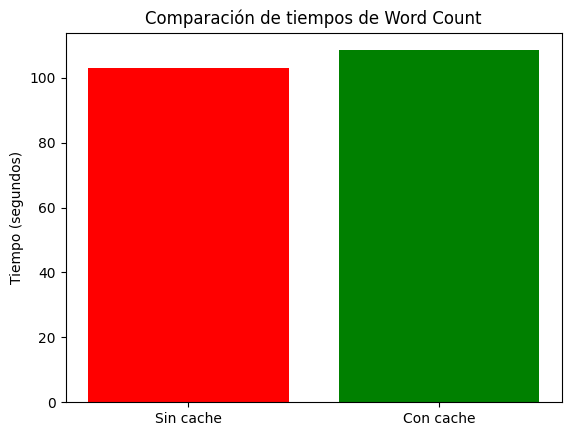

In [9]:
plt.bar(["Sin cache", "Con cache"], [time_no_cache, time_cache], color=["red", "green"])
plt.title("Comparación de tiempos de Word Count")
plt.ylabel("Tiempo (segundos)")
plt.show()


## Cálculo de rating promedio por libro

In [29]:
from pyspark import StorageLevel
from time import time
import matplotlib.pyplot as plt
start = time()
avg_rating_per_book = (
    reviews_rdd
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    .mapValues(lambda pair: pair[0] / pair[1])
)
print("Tiempo promedio rating por libro:", time() - start)

Tiempo promedio rating por libro: 0.03366994857788086


Asumimos que reviews_rdd tiene pares (book_id, (rating, 1))

reduceByKey: Combina los valores para cada book_id sumando los ratings y los conteos.

mapValues: Calcula el promedio dividiendo la suma de ratings por el conteo.

## Conteo de ratings por libro

In [16]:
start = time()
ratings_count_per_book = (
    reviews_rdd
    .mapValues(lambda x: 1)
    .reduceByKey(lambda a, b: a + b)
)
ratings_count_per_book.take(5)
print("Tiempo conteo de ratings por libro:", time() - start)

[Stage 13:============================================>           (49 + 9) / 61]

Tiempo conteo de ratings por libro: 12.573649644851685


In [17]:
ratings_count_per_book.take(5)

[('7', 103), ('B', 1565561), ('0', 1025169), ('2', 2097), ('1', 372495)]

mapValues: Para cada reseña, devuelve 1 (queremos contar, no sumar ratings).

reduceByKey: Cuenta las reseñas sumando los unos para cada book_id.

## Análisis de palabras en títulos

In [21]:
books_header = books_rdd.first()

titles_rdd = (
    books_rdd
    .filter(lambda line: line != books_header)
    .map(lambda line: line.split(",")[1])  # Suponiendo título en la segunda columna
)

word_counts = ( 
    titles_rdd
    .flatMap(lambda title: title.lower().split(" "))
    .map(lambda word: (word, 1))
    .reduceByKey(lambda a, b: a + b)
    .sortBy(lambda x: -x[1])
)


filter: Elimina la línea de encabezado del CSV.

map: Extrae solo la columna de título.

flatMap: Divide cada título en palabras individuales.

map: Crea pares (palabra, 1) para contar.

reduceByKey: Suma las ocurrencias de cada palabra.

sortBy: Ordena las palabras por frecuencia descendente.

filter: Elimina palabras vacías y stopwords comunes.

In [22]:
word_counts.take(10)

[('the', 136625),
 ('of', 105066),
 ('', 85397),
 ('and', 70292),
 ('a', 56350),
 ('to', 49943),
 ('in', 43774),
 ('is', 26649),
 ('for', 21908),
 ('with', 15743)]

In [25]:
stopwords = {
    "the", "a", "an", "and", "or", "of", "in", "on", "for", "with",
    "at", "by", "to", "from", "is", "are", "was", "were", "be", "as",
    "this", "that", "it", "its", "but", "not", "so"
}
word_counts_filtered = (
    word_counts
    .filter(lambda wc: wc[0] and wc[0] not in stopwords)
)

top_words = word_counts_filtered.take(10)
for word, count in top_words:
    print(f"{word}: {count}")

book: 13009
"the: 11684
his: 9154
"a: 8544
new: 8427
"this: 8395
.: 7609
you: 7258
her: 6445
has: 6155


In [5]:
# Cargar datos con inferencia de esquema controlada
reviews_df = spark.read.csv(
    "/data/Books_rating.csv",
    header=True,
    inferSchema=True,
    samplingRatio=0.1  # Muestrea solo el 10% para inferir el esquema
)

# Verificar esquema y memoria usada
print("Esquema del DataFrame:")
reviews_df.printSchema()
print(f"Número de particiones: {reviews_df.rdd.getNumPartitions()}")

[Stage 7:======================================================>  (21 + 1) / 22]

Esquema del DataFrame:
root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: string (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)

Número de particiones: 22


## Uso de persist

In [18]:
from pyspark import StorageLevel
# Seleccionar solo las columnas necesarias
cols_needed = ["Title", "review/score", "review/summary"]
reviews_df = reviews_df.select(cols_needed)

# Convertir y limpiar datos
reviews_clean = reviews_df.withColumn(
    "review_score",
    when(col("review/score").cast("double").isNull(), 0.0)
    .otherwise(col("review/score").cast("double"))
).drop("review/score")

# Persistencia con nivel óptimo
reviews_clean.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[Title: string, review/summary: string, review_score: double]

In [19]:
optimized_avg = reviews_clean.repartition(16, "Title") \
    .groupBy("Title") \
    .agg(
        avg("review_score").alias("avg_rating"),
        count("*").alias("review_count")
    )

# Forzar la presencia de columnas clave (opcional)
optimized_avg = optimized_avg.select("Title", "avg_rating", "review_count")

# Mostrar resultados
optimized_avg.show(20, truncate=False)

[Stage 28:================================================>       (19 + 3) / 22]

+------------------------------------------------------------------------------------------------+------------------+------------+
|Title                                                                                           |avg_rating        |review_count|
+------------------------------------------------------------------------------------------------+------------------+------------+
|Pronti...Via!: Beginning Italian (Yale Language Series)                                         |4.0               |2           |
|Outcast Cape Town                                                                               |5.0               |1           |
|Administering Sap R/3: Sd-Sales and Distribution Module                                         |1.25              |8           |
|Alfred & Guinevere                                                                              |4.0               |5           |
|McSe Readiness Review Exam 70-059: Internetworking With Tcp/Ip on Microsoft Window